In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1a. Загрузка и обработка данных

In [2]:
df = pd.read_csv('https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/NRG_CB_GASM?format=SDMX-CSV')
df = df[df.nrg_bal.eq('IC_CAL_MG') & df.unit.eq('MIO_M3')][['TIME_PERIOD', 'geo', 'OBS_VALUE']]
data = df.pivot('TIME_PERIOD', 'geo', 'OBS_VALUE')

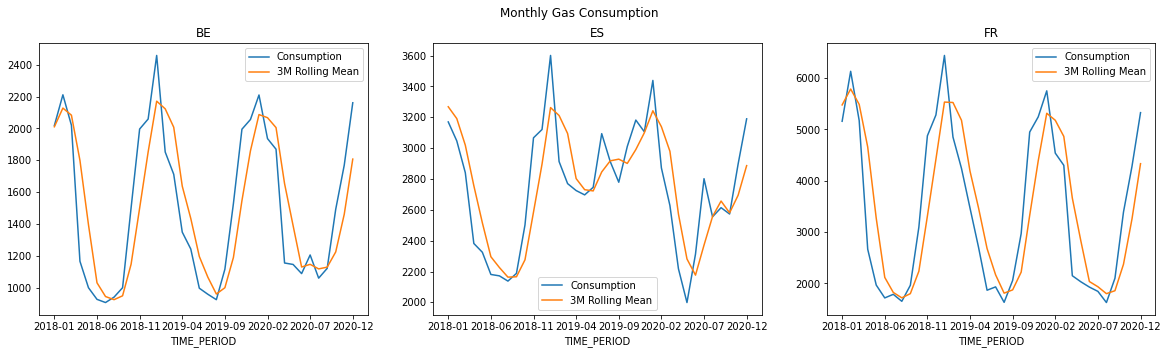

In [4]:
tfig, axes = plt.subplots(1, 3, figsize=(20, 5));

for state, ax in zip(('BE', 'ES', 'FR'), axes):
  data[state].loc['2018':'2021'].plot(ax=ax, label='Consumption');
  data.rolling(3).mean()[state].loc['2018':'2021'].plot(ax=ax, label='3M Rolling Mean');
  ax.legend();
  ax.set_title(state);
plt.suptitle('Monthly Gas Consumption');

In [5]:
seasons = {1: 'winter', 2: 'spring', 3: 'summer', 4: 'autumn'}
data['season'] = (pd.to_datetime(data.index).month % 12 // 3 + 1).map(seasons)
data['year'] = pd.to_datetime(pd.to_datetime(data.index).year.map(str))

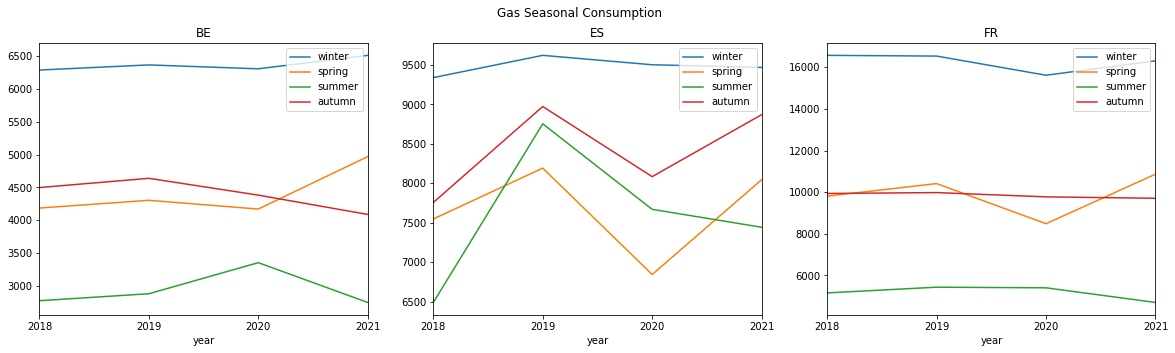

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5));

for state, ax in zip(('BE', 'ES', 'FR'), axes):

  data1 = data.groupby(['season', 'year']).sum().reset_index('season').loc['2018':'2021']
  for season in seasons.values():
    data1[data1.season.eq(season)][state].plot(ax=ax, label=season)
  ax.legend();
  ax.set_title(state);
plt.suptitle('Gas Seasonal Consumption');

# 1b. Прогнозирование временных рядов

In [13]:
data.loc[:'2021'].isna().mean()

geo
AL           0.571429
AT           0.000000
BE           0.000000
BG           0.000000
CY           0.142857
CZ           0.000000
DE           0.000000
DK           0.000000
EA           0.011905
EA19         0.000000
EE           0.000000
EL           0.000000
ES           0.000000
EU27_2020    0.000000
FI           0.000000
FR           0.000000
GE           0.571429
HR           0.000000
HU           0.000000
IE           0.000000
IT           0.000000
LT           0.000000
LU           0.000000
LV           0.000000
MD           0.857143
ME           1.000000
MK           0.011905
MT           0.000000
NL           0.000000
NO           0.000000
PL           0.000000
PT           0.000000
RO           0.000000
RS           0.428571
SE           0.000000
SI           0.000000
SK           0.000000
TR           0.000000
UA           0.857143
UK           0.023810
dtype: float64

## VECM & ARIMA

Сначала я применю модель VECM для многомерных временных рядов. Модель предсказывает будущие значения, используя информацию о краткосрочных и долгосрочных связях между рядами. Модель оценивает уравнение для первых разностей ряда.
Не смотря на фактическое предсказание на 1 период, с помощью модели можно получать предсказание на любое количество периодов вперед. В этой модели я буду моделировать те страны, у которых мало пропусков (меньше 10%). Те страны, которые не попадут в это число, будут смоделированы с помощью модели AUTO.ARIMA, которая самостоятельно подбирает параметры модели ARIMA. Я не моделирую страны, в которых нет никаких данных (все данные - пропуски). Для обеих моделей я использую логарифмы данных, чтобы они оценивали лог-доходности при переходе к первым разностям. Также в обеих моделях я учитываю годовую сезонность.

В тренировочные данные попадают все наблюдения по апрель 2021-го года. На тренировочных данных оцениваются параметры моделей. Далее каждая модель делает предсказания для своих стран на 12 месяцев вперед от последнего наблюдения в тренировочной выборке. Я беру последние 3 предсказания, перевожу их из логарифма в исходные значения, и сравниваю с настоящими значениями первого квартала 2022-го года с помощью MSE.



In [ ]:
!pip install pmdarima

In [45]:
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.vector_ar.var_model import VAR
from pmdarima.arima import auto_arima, is_constant

In [96]:
mask = data.loc[:'2021-03'].apply(np.log).replace([np.inf, -np.inf], np.nan).isna()

In [97]:
vecm_states = data.columns[mask.mean() < 0.1]
arima_states = data.columns[mask.mean() > 0.1]

In [99]:
data_vecm = data.loc[:'2021-03'][vecm_states].apply(np.log).ffill().dropna().astype('float32')
data_arima = data.loc[:'2021-03'][arima_states].dropna(axis=1, how='all').ffill()

In [100]:
vecm = VECM(data_vecm.values, k_ar_diff=1, deterministic='co', seasons=12).fit()

In [101]:
forecast_vecm = np.exp(vecm.predict(12, alpha=None))

In [102]:
forecast_arima = []
for state in data_arima:
  state_data = data_arima[state].dropna().values
  if is_constant(state_data):
    pred = np.full(12, state_data[-1])
  else:
    state_data = np.log(state_data[state_data > 0])
    try: arima = auto_arima(state_data, m=12, seasonal=True)
    except: arima = auto_arima(state_data, m=3, seasonal=True)
    pred = np.exp(arima.predict(12))
  forecast_arima.append(pred)

forecast_arima = np.stack(forecast_arima).T

In [103]:
forecast = np.hstack([forecast_vecm, forecast_arima])

In [117]:
used_states = np.hstack([data_vecm.columns, data_arima.columns])

preds = pd.DataFrame(forecast[-3:, :], columns=used_states)
actuals = data[used_states].loc['2022':'2022-03'].dropna(axis=1, how='any')

used_states = actuals.columns
preds = preds[used_states]

Считаю MSE предсказанных и настоящих значений 2022Q1.

In [119]:
print('MSE: ', np.square(preds.values - actuals.values).mean())

MSE:  1326785.626793431


Предсказанные значения.

In [125]:
preds

,AT,BE,BG,CZ,DE,DK,EA,EE,EL,ES,...,PT,RO,SI,SK,TR,CY,GE,MD,MT,RS
0,1307.176940,2192.837144,514.429488,1361.836115,13705.256068,340.224241,45164.561488,65.574428,788.217170,3416.455857,...,565.803971,1532.548628,129.918897,668.116805,8870.284835,0.0,405.085836,93.750602,23.558130,376.946248
1,1063.436294,1905.617663,420.158772,1146.781151,11731.256871,307.065130,38281.303659,57.424971,589.843830,2866.259305,...,456.540270,1355.689774,110.251929,585.488197,7323.330412,0.0,349.276375,121.688747,23.184475,296.001362
2,957.007789,1737.084726,402.931750,1011.798304,10767.352174,281.964086,34675.434582,52.307266,528.395219,2785.279598,...,473.266336,1158.940377,103.234319,526.015461,6824.289791,0.0,269.850395,132.632903,22.835318,234.568850


Настоящие значения.

In [124]:
actuals

geo,AT,BE,BG,CZ,DE,DK,EA,EE,EL,ES,...,PT,RO,SI,SK,TR,CY,GE,MD,MT,RS
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,
2022-01,1155.645,2207.9,384.381,1123.429,12107.641,302.630,42529.792,60.4,581.068,3740.969,...,536.293,1591.0,116.420,743.655,7136.59,0.0,438.04,187.9,28.881,440.0
2022-02,970.313,1683.7,316.623,891.981,9883.820,261.107,33727.604,49.8,502.811,3098.425,...,450.303,1263.0,92.574,556.502,6137.63,0.0,359.70,137.3,26.450,347.0
2022-03,1000.793,1540.2,348.975,902.109,9444.382,267.465,33706.606,45.3,645.018,3046.881,...,484.574,1247.0,95.770,858.338,6951.15,0.0,425.26,149.3,29.256,374.0


## Facebook Prophet

Еще я использую модель Prophet от Facebook для предсказания одномерных временных рядов. Эта модель оценивает нелинейные тренды в данных, учитывая сезональность и другие свойства. Я получаю предсказания из этой модели отдельно для каждой страны, для которой доступны наблюдения. Весь остальной пайплайн повторяет пайплайн для предыдущего случая.

In [ ]:
!pip install prophet

In [129]:
from prophet import Prophet

In [141]:
train_data = data.loc[:'2021-03'].dropna(axis=1, how='all').ffill()
train_data = train_data.reset_index().rename(columns={'TIME_PERIOD': 'ds'})
train_data['ds'] = pd.to_datetime(train_data.ds)

In [159]:
forecast_prophet = []

forecast_arima = []
for state in train_data.columns[1:]:
  state_data = train_data[['ds', state]].dropna().rename(columns={state: 'y'})
  if is_constant(state_data['y']):
    pred = np.full(12, state_data['y'].iloc[-1])
  else:
    state_data = state_data[state_data['y'] > 0]
    state_data['y'] = np.log(state_data['y'])
    
    m = Prophet(weekly_seasonality=False, daily_seasonality=False)
    m.fit(state_data)
    future = m.make_future_dataframe(periods=12, freq='MS')
    pred = m.predict(future)['yhat'].apply(np.exp).values[-12:]

  forecast_prophet.append(pred)

forecast_prophet = np.stack(forecast_prophet).T

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.


In [161]:
used_states = train_data.columns[1:]

preds = pd.DataFrame(forecast_prophet[-3:, :], columns=used_states)
actuals = data[used_states].loc['2022':'2022-03'].dropna(axis=1, how='any')

used_states = actuals.columns
preds = preds[used_states]

Считаю MSE предсказанных и настоящих значений 2022Q1.

In [162]:
print('MSE: ', np.square(preds.values - actuals.values).mean())

MSE:  1233015.758553441


Предсказанные значения.

In [163]:
preds

geo,AT,BE,BG,CY,CZ,DE,DK,EA,EE,EL,...,MT,NL,NO,PL,PT,RO,RS,SI,SK,TR
0,1245.800640,2498.917081,441.033006,0.0,1414.945729,12697.524677,405.330707,45057.480157,63.974801,734.132653,...,25.592652,6137.225052,400.327580,2905.362597,512.453697,1614.436434,548.670676,117.674175,923.774782,7256.167113
1,1022.335314,2132.379189,370.423990,0.0,1206.863578,10756.629000,361.382711,37873.772319,56.112262,563.943372,...,33.633133,5294.017014,541.671616,2552.419167,424.460379,1491.526554,456.021209,102.178458,834.377422,6300.486660
2,950.574049,1979.896598,356.582260,0.0,1088.361090,9900.982451,340.154444,34760.743168,52.321915,508.742583,...,28.924252,4667.636945,616.084395,2508.821872,419.293050,1287.746786,407.253148,95.318499,751.856169,5797.087845


Настоящие значения.

In [165]:
actuals

geo,AT,BE,BG,CY,CZ,DE,DK,EA,EE,EL,...,MT,NL,NO,PL,PT,RO,RS,SI,SK,TR
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,
2022-01,1155.645,2207.9,384.381,0.0,1123.429,12107.641,302.630,42529.792,60.4,581.068,...,28.881,4491.908,686.292,1829.900,536.293,1591.0,440.0,116.420,743.655,7136.59
2022-02,970.313,1683.7,316.623,0.0,891.981,9883.820,261.107,33727.604,49.8,502.811,...,26.450,3601.161,618.232,1971.766,450.303,1263.0,347.0,92.574,556.502,6137.63
2022-03,1000.793,1540.2,348.975,0.0,902.109,9444.382,267.465,33706.606,45.3,645.018,...,29.256,3423.336,9676.034,1996.368,484.574,1247.0,374.0,95.770,858.338,6951.15


# Моделирование рынка

Рассмотрим некоторое упрощение HJM модели. Представим, что цена фьючерса $F$ определяется через текущую стоимость акции $S$ как $F(\tau)=S \cdot e^{\int^{\tau}_{0} f(r)\,dr}$, где $f(\tau)$ это мгновенная форвардная ставка в момент времени $\tau$.
Пусть нам доступны значения цен в моменты $\tau_0=0, \tau_1, ..., \tau_n$. Заметим, что $F(\tau_i)/F(\tau_{i-1})=e^{\int^{\tau_i}_{\tau_{i-1}} f(r)\,dr}$.

Приблизим кривую $f(\tau)$ с помощью семейства полиномов $G(n)$ степени не выше $n$:
$f^*(.) = argmin_{g \in G(n)} \int^{T}_{0} (g''(r))^2\,dr + \sum^n_{i=1} (F(\tau_i)/F(\tau_{i-1}) - e^{\int^{\tau_i}_{\tau_{i-1}} g(r)dr})^2$.
Для получения $F(\tau)$ далее считаем $S \cdot e^{\int^{\tau}_{0} f^*(r)\,dr}$, где интеграл считается приближенными численными методами.

In [303]:
from scipy.optimize import minimize
from scipy.integrate import quad
from datetime import datetime

Я предзагружаю данные с сайта, так как через методы Python не получается получить доступ к ссылке.

In [354]:
futures = pd.read_excel('Dutch TTF Natural Gas Calendar Month.xlsx')
futures = futures[['MONTH', 'PRIOR']]
futures = futures.rename(columns={'PRIOR': 'f', 'MONTH': 'date'}).dropna().reset_index(drop=True)
futures['f'] = futures['f'].astype('float')

first_row = pd.DataFrame({'date': datetime.today().date(),
                          'f': futures.f[0] * 0.99}, index=[0])
futures = pd.concat([first_row, futures]).reset_index(drop=True)
futures['date'] = pd.to_datetime(futures['date'])
futures = futures[futures.date <= '2026-12-01']
futures['timed'] = (futures['date'] - datetime.today()).dt.days / 365

In [355]:
first_row

,date,f
0,2022-06-15,96.0696


In [356]:
futures.head()

,date,f,timed
0,2022-06-15,96.0696,-0.002740
1,2022-07-01,97.0400,0.041096
2,2022-08-01,98.2050,0.126027
3,2022-09-01,99.8950,0.210959
4,2022-10-01,102.3350,0.293151


In [357]:
train = futures.iloc[:36]

In [358]:
def poly(x, a):
  return sum([coef * x ** pow for pow, coef in enumerate(a)])

def integral_poly(a, x_start, x_end):
  a_mod = a / np.arange(1, len(a) + 1)
  return poly(x_end, a_mod) * x_end - poly(x_start, a_mod) * x_start

def second_dev(a, x):
  return sum([pow * (pow - 1) * coef * x ** (pow - 2)
              for pow, coef in enumerate(a) if pow > 1])
  
def sq_second_dev(x, a):
  return second_dev(a, x) ** 2

def third_dev(a, x):
  return sum([pow * (pow - 1) * (pow - 2) * coef * x ** (pow - 3)
              for pow, coef in enumerate(a) if pow > 2])

def obj_func(a, prices, T, taus):
  part1 = quad(sq_second_dev, 0, T, args=(a, ))[0]
  part2 = sum([(prices[i] / prices[i - 1] - np.exp(-integral_poly(a, taus[i - 1], taus[i]))) ** 2
              for i in range(1, len(prices))])
  return part1 + part2

In [471]:
l = len(futures)
T = futures.timed.iloc[-1]
n = 6
res = minimize(obj_func, np.ones(n), args=(train.f, T, train.timed), bounds=[(-10, 10)] * n)
res

      fun: 0.060104533151653955
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.02167842, -0.01425454,  0.00080007, -0.00247687, -0.01036994,
       -0.05958694])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 574
      nit: 70
   status: 0
  success: True
        x: array([ 3.09248670e-01, -2.59748404e-02,  4.65748508e-03, -3.48469212e-04,
       -6.25028141e-05,  8.41084593e-06])

In [472]:
disc = (futures.f / futures.f.shift()).values
disc[0] = 1

for i in range(36, disc.shape[0]):
  disc[i] = np.exp(-quad(poly, futures.timed.iloc[i - 1],
                         futures.timed.iloc[i], args=(res['x'], ))[0])
disc = np.cumprod(disc)
futures['disc'] = disc
futures['pred'] = futures.f.iloc[0] * futures.disc

Считаю MSE между предсказанными ценами и настоящими.

In [473]:
print('MSE: ', (futures.pred - futures.f).iloc[36:].pow(2).mean())

MSE:  9.049547373278253


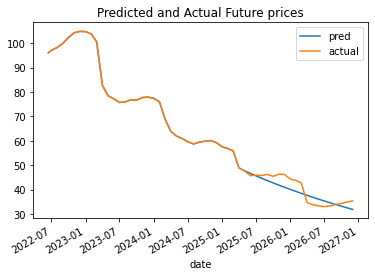

In [475]:
futures.set_index('date')[['pred', 'f']].rename(columns={'f': 'actual'}).plot(title='Predicted and Actual Future prices');